<a href="https://colab.research.google.com/github/KoreTane/interesting/blob/main/ClusterC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install yellowbrick

###Segmentação de Clientes

#### Utilizaremos análise de clusters para segmentar nossos dados utilizando algoritmos de clustering, K-Means e Gaussian Mixture Model (GMM). Nosso objetivo é identificar grupos distintos dentro dos dados com características similares, facilitando a criação de estratégias mais direcionadas e eficientes.**

###Análise Exploratória:

####Normalização e preparação dos dados para garantir que todas as características estejam na mesma escala.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from pyspark.sql.types import FloatType
from ipywidgets import interact, IntSlider
import plotly.express as px
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score, silhouette_score

spark = SparkSession.builder.appName("ClusterCompras").getOrCreate()

df = spark.read.csv("online.csv", header=True, inferSchema=True)
df.printSchema()
df.describe().show(truncate=False)
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)

+-------+-----------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|summary|Invoice          |StockCode         |Description                        |Quantity          |Price             |Customer ID       |Country    |
+-------+-----------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|count  |259454           |259454            |257480                             |259453            |259453            |202858            |259453     |
|mean   |501718.8920116595|32261.525741525424|21494.0    

In [2]:
# Preencher valores nulos na coluna Description
df = df.fillna({'Description': 'No description'})

df = df.filter(col("Customer ID").isNotNull())

In [6]:
from pyspark.sql.functions import col

# Filtrar o DataFrame para obter apenas os valores de Invoice que começam com "C"
invoices_comecam_com_c = df.filter(col("Invoice").startswith("C"))

# Mostrar os resultados
#invoices_comecam_com_c.show().count()
invoices_comecam_com_c.count()

5383

In [4]:
# 1. Identificar clientes que só devolveram e não compraram nada
# Agrupar por "Customer ID" e calcular a soma e contagem de "Quantity"
clientes_somente_devolucoes = df.groupBy("Customer ID") \
                                .agg(sum("Quantity").alias("TotalQuantity"),
                                     count(when(col("Quantity") > 0, 1)).alias("CountPositiveQuantity")) \
                                .filter((col("TotalQuantity") < 0) & (col("CountPositiveQuantity") == 0))

# 2. Mostrar os clientes que devolveram mais quantity
clientes_somente_devolucoes_ordenado = clientes_somente_devolucoes.orderBy(col("TotalQuantity").asc())
clientes_somente_devolucoes_ordenado.show(truncate=False)

# 3. Contar o número de clientes que só devolveram
clientes_unicos_somente_devolucoes = clientes_somente_devolucoes_ordenado.distinct().count()
print(f'Número de clientes únicos que só devolveram: {clientes_unicos_somente_devolucoes}')

# 4. Extrair IDs dos clientes para serem removidos
clientes_somente_devolucoes_ids = clientes_somente_devolucoes_ordenado.select("Customer ID").rdd.flatMap(lambda x: x).collect()

# 5. Filtrar o DataFrame original para remover esses clientes
df = df.filter(~col("Customer ID").isin(clientes_somente_devolucoes_ids))

df_filtrado = df.filter(~col("Invoice").contains('C'))

# 6. Confirmar a remoção
unique_customers_after_removal = df.select("Customer ID").distinct().count()
print(f'Número de clientes únicos após remoção: {unique_customers_after_removal}')

+-----------+-------------+---------------------+
|Customer ID|TotalQuantity|CountPositiveQuantity|
+-----------+-------------+---------------------+
|14337.0    |-393         |0                    |
|15935.0    |-286         |0                    |
|15767.0    |-50          |0                    |
|16001.0    |-32          |0                    |
|13281.0    |-25          |0                    |
|12770.0    |-23          |0                    |
|16128.0    |-21          |0                    |
|14864.0    |-17          |0                    |
|13528.0    |-16          |0                    |
|12907.0    |-13          |0                    |
|15997.0    |-12          |0                    |
|16262.0    |-12          |0                    |
|14627.0    |-10          |0                    |
|16853.0    |-10          |0                    |
|17485.0    |-9           |0                    |
|17661.0    |-8           |0                    |
|13915.0    |-8           |0                    |


In [34]:
df.describe().show(truncate=False)

+-------+-----------------+------------------+-----------------------------------+-----------------+-----------------+------------------+-----------+------------------+------------------+------------------+------------------+-------------------+
|summary|Invoice          |StockCode         |Description                        |Quantity         |Price            |Customer ID       |Country    |TotalPrice        |TotalSpent        |DayOfWeek         |HourOfDay         |Returns            |
+-------+-----------------+------------------+-----------------------------------+-----------------+-----------------+------------------+-----------+------------------+------------------+------------------+------------------+-------------------+
|count  |202482           |202482            |202482                             |202482           |202482           |202482            |202482     |202482            |202482            |202482            |202482            |202482             |
|mean   |502104.

In [5]:
# investigar o comportamento do cliente com maior n de devoluções, que aparentemtne devolveu toda a compra
cliente_info = df.filter(col("Customer ID") == 14337.0).toPandas()

print(f'Informações do Cliente com Customer ID = 14337.0:')
print(cliente_info)

Informações do Cliente com Customer ID = 14337.0:
Empty DataFrame
Columns: [Invoice, StockCode, Description, Quantity, InvoiceDate, Price, Customer ID, Country]
Index: []


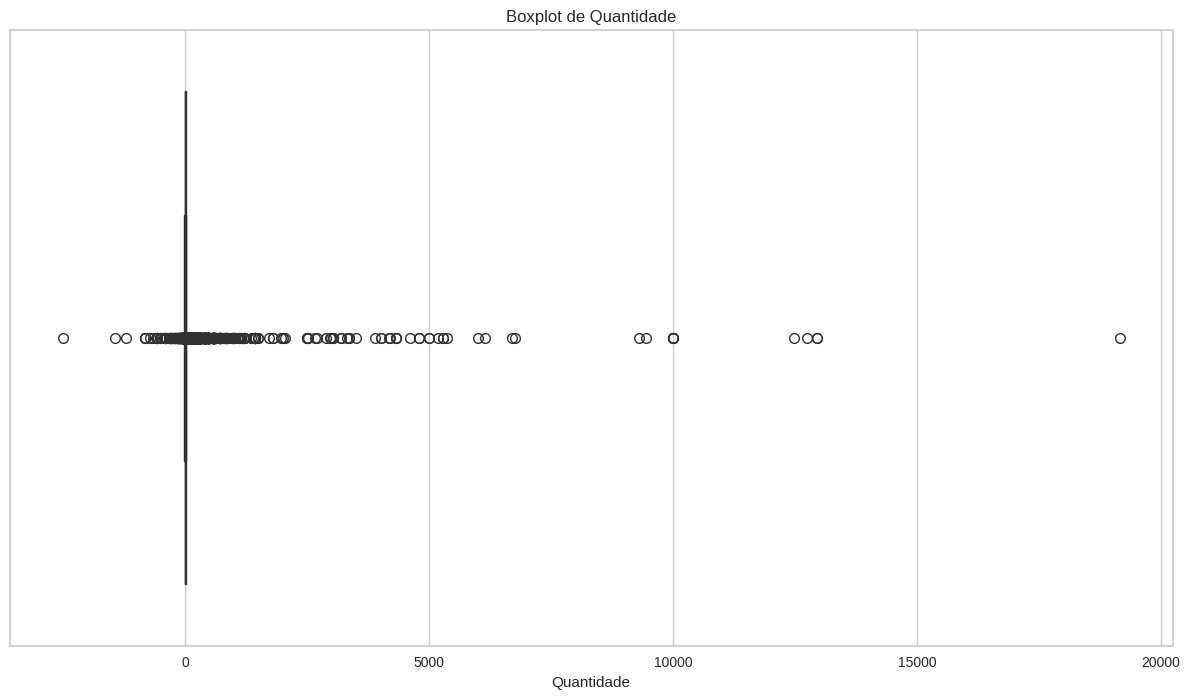

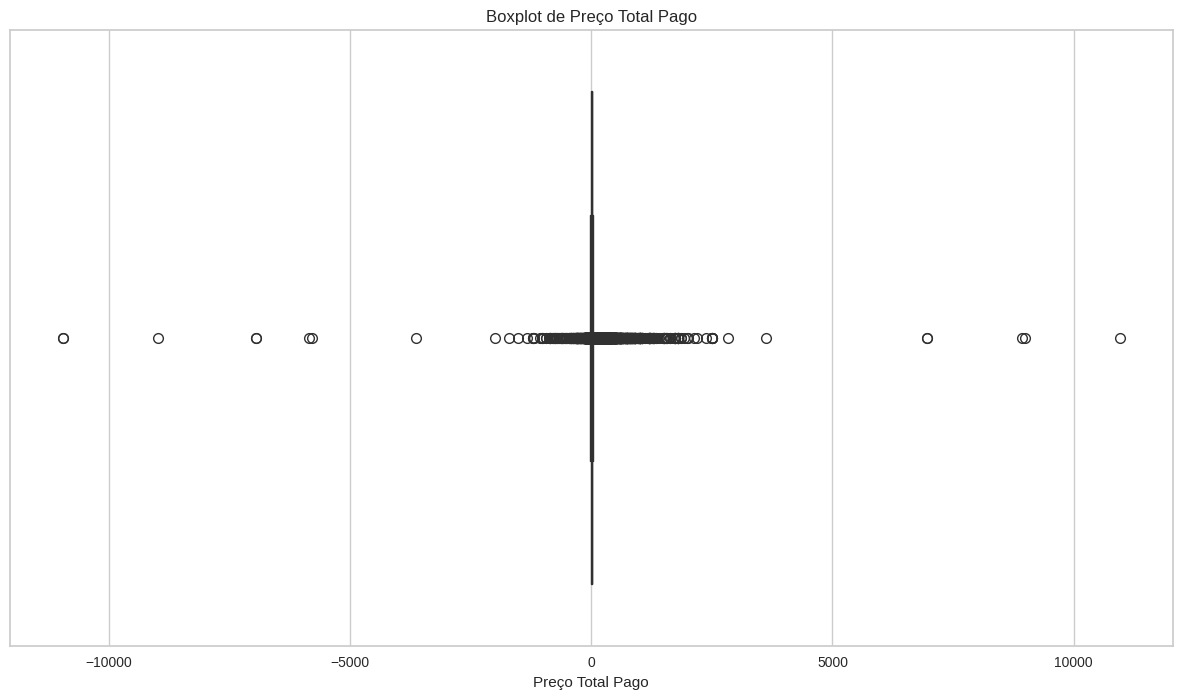

In [6]:
# os dados estão concentrados próximos a média vamos explorar os outliers
df = df.withColumn("TotalPrice", col("Quantity") * col("Price"))
quantity_pd = df.select("Quantity").toPandas()
price_pd = df.select("Price").toPandas()
total_price_pd = df.select("TotalPrice").toPandas()

# Boxplot de Quantidade
plt.figure(figsize=(15, 8))
sns.boxplot(x=quantity_pd["Quantity"])
plt.title("Boxplot de Quantidade")
plt.xlabel("Quantidade")
plt.show()

# Boxplot de Preço Total Pago
plt.figure(figsize=(15, 8))
sns.boxplot(x=total_price_pd["TotalPrice"])
plt.title("Boxplot de Preço Total Pago")
plt.xlabel("Preço Total Pago")
plt.show()

In [7]:
# Os outliears são principalmente provenientes de extornos e de compras anteriores ao período considerado, podemos E L I M I N A L O S para essa análisae

quantity_greater_20000 = df.filter(col("Quantity") > 10000).count()
quantity_less_20000 = df.filter(col("Quantity") < -10000).count()
price_greater_20000 = df.filter(col("TotalPrice") > 15000).count()
price_less_20000 = df.filter(col("TotalPrice") < -15000).count()

print("Quantidade de valores em Quantity > 20000:", quantity_greater_20000)
print("Quantidade de valores em Quantity < -20000:", quantity_less_20000)
print("Quantidade de valores em Price > 20000:", price_greater_20000)
print("Quantidade de valores em Price < -20000:", price_less_20000)

df = df.filter((col("Quantity") <= 15000) & (col("Quantity") >= -15000))

df = df.filter((col("TotalPrice") <= 12000) & (col("TotalPrice") >= -12000))
#outlier, cliente que fez muitas devoluções e comprou antes do tempo de analise
df = df.filter(~col("Customer ID").isin([14277.0,15838.0,12931.0]))

Quantidade de valores em Quantity > 20000: 5
Quantidade de valores em Quantity < -20000: 0
Quantidade de valores em Price > 20000: 0
Quantidade de valores em Price < -20000: 0


In [8]:
from pyspark.sql.functions import col

# Filtrar para transações onde Quantity < 0 (devoluções)
devolucoes = df.filter(col("Quantity") < 0)

# Agregar os dados por Customer ID e somar a coluna Quantity para obter o total de devoluções
clientes_com_devolucoes = devolucoes.groupBy("Customer ID") \
                                    .agg(sum("Quantity").alias("TotalReturns")) \
                                    .orderBy(col("TotalReturns").asc())

# Mostrar os clientes com mais devoluçõesz
clientes_com_devolucoes.show(truncate=False)


+-----------+------------+
|Customer ID|TotalReturns|
+-----------+------------+
|16754.0    |-8988       |
|17949.0    |-3157       |
|13902.0    |-2510       |
|14028.0    |-2490       |
|13091.0    |-2408       |
|13694.0    |-2206       |
|12971.0    |-1440       |
|14156.0    |-756        |
|15311.0    |-704        |
|16684.0    |-672        |
|18102.0    |-622        |
|14646.0    |-519        |
|13089.0    |-417        |
|14748.0    |-400        |
|14727.0    |-392        |
|15061.0    |-348        |
|16656.0    |-342        |
|17679.0    |-341        |
|15222.0    |-312        |
|16077.0    |-312        |
+-----------+------------+
only showing top 20 rows



In [9]:
df.describe().show(truncate=False)

+-------+-----------------+------------------+-----------------------------------+-----------------+-----------------+------------------+-----------+------------------+
|summary|Invoice          |StockCode         |Description                        |Quantity         |Price            |Customer ID       |Country    |TotalPrice        |
+-------+-----------------+------------------+-----------------------------------+-----------------+-----------------+------------------+-----------+------------------+
|count  |202482           |202482            |202482                             |202482           |202482           |202482            |202482     |202482            |
|mean   |502104.261514608 |31933.708596363635|NULL                               |13.3947758319258 |3.859489786747629|15332.89079523118 |NULL       |20.253459621100475|
|stddev |7261.361181342051|22037.01534766668 |NULL                               |105.4287095539334|63.86279511280899|1681.5144014937114|NULL       |88.480

In [10]:
# Identificar o cliente no cluster específico
#cliente_unico = features_df[features_df['prediction'] == 5]

# Extrair o ID do cliente
#cliente_id = 14277.0 #cliente_unico.index[0]  # Supondo que 'Customer ID' é o índice

# Visualizar as características do cliente
#print(f'Características do Cliente Único (ID: {cliente_id}):')
#print(cliente_unico)

# Analisar o histórico de compras do cliente
#historico_compras = df.filter(col("Customer ID") == cliente_id).toPandas()

# Exibir o histórico de compras
#print(f'Histórico de Compras do Cliente Único (ID: {cliente_id}):')
#print(historico_compras)


In [11]:
df.groupBy(year("InvoiceDate").alias("Ano")) \
  .agg(countDistinct("Invoice").alias("TotalOrders"),
       sum("Price").alias("TotalSpent"),
       (sum("Price") / countDistinct("Invoice")).alias("AvgTicket")) \
  .orderBy("TotalOrders", ascending=False) \
  .show()

df.groupBy(month("InvoiceDate").alias("Mês")) \
  .agg(countDistinct("Invoice").alias("TotalOrders"),
       sum("Price").alias("TotalSpent"),
       (sum("Price") / countDistinct("Invoice")).alias("AvgTicket")) \
  .orderBy("TotalOrders", ascending=False) \
  .show()


df.groupBy(dayofmonth("InvoiceDate").alias("Dia")) \
  .agg(countDistinct("Invoice").alias("TotalOrders"),
       sum("Price").alias("TotalSpent"),
       (sum("Price") / countDistinct("Invoice")).alias("AvgTicket")) \
  .orderBy("TotalOrders", ascending=False) \
  .show()

df.groupBy("Country") \
  .agg(countDistinct("Invoice").alias("TotalOrders"),
       sum("Price").alias("TotalSpent"),
       (sum("Price") / countDistinct("Invoice")).alias("AvgTicket")) \
  .orderBy("TotalOrders", ascending=False) \
  .show()

df.groupBy("StockCode", "Description").agg(sum("Quantity").alias("TotalQuantity"), sum("Price").alias("TotalPrice")).orderBy("TotalQuantity", ascending=False).show()

df.groupBy("Customer ID").agg(countDistinct("Invoice").alias("TotalOrders"), sum("Price").alias("TotalSpent")).orderBy("TotalSpent", ascending=False).show()

correlation = df.select("Quantity", "TotalPrice").corr("Quantity", "TotalPrice")
print("Correlação entre Quantity e TotalPrice:", correlation)

+----+-----------+-----------------+-----------------+
| Ano|TotalOrders|       TotalSpent|        AvgTicket|
+----+-----------+-----------------+-----------------+
|2010|       9787|675534.5409999966|69.02365801573481|
|2009|       1866|105942.6699999997|56.77527867095375|
+----+-----------+-----------------+-----------------+

+---+-----------+------------------+------------------+
|Mês|TotalOrders|        TotalSpent|         AvgTicket|
+---+-----------+------------------+------------------+
|  3|       1886|173067.00099999987|  91.7640514316012|
| 12|       1866|105942.66999999972| 56.77527867095376|
|  6|       1823|110135.89999999966| 60.41464618760266|
|  5|       1755| 98908.24999999978|56.357977207977086|
|  4|       1599|100341.71199999985|62.752790494058694|
|  2|       1331| 81467.08599999991|61.207427498121646|
|  1|       1271|104502.66199999978| 82.22081982690777|
|  7|        122| 7111.929999999995| 58.29450819672127|
+---+-----------+------------------+-----------------

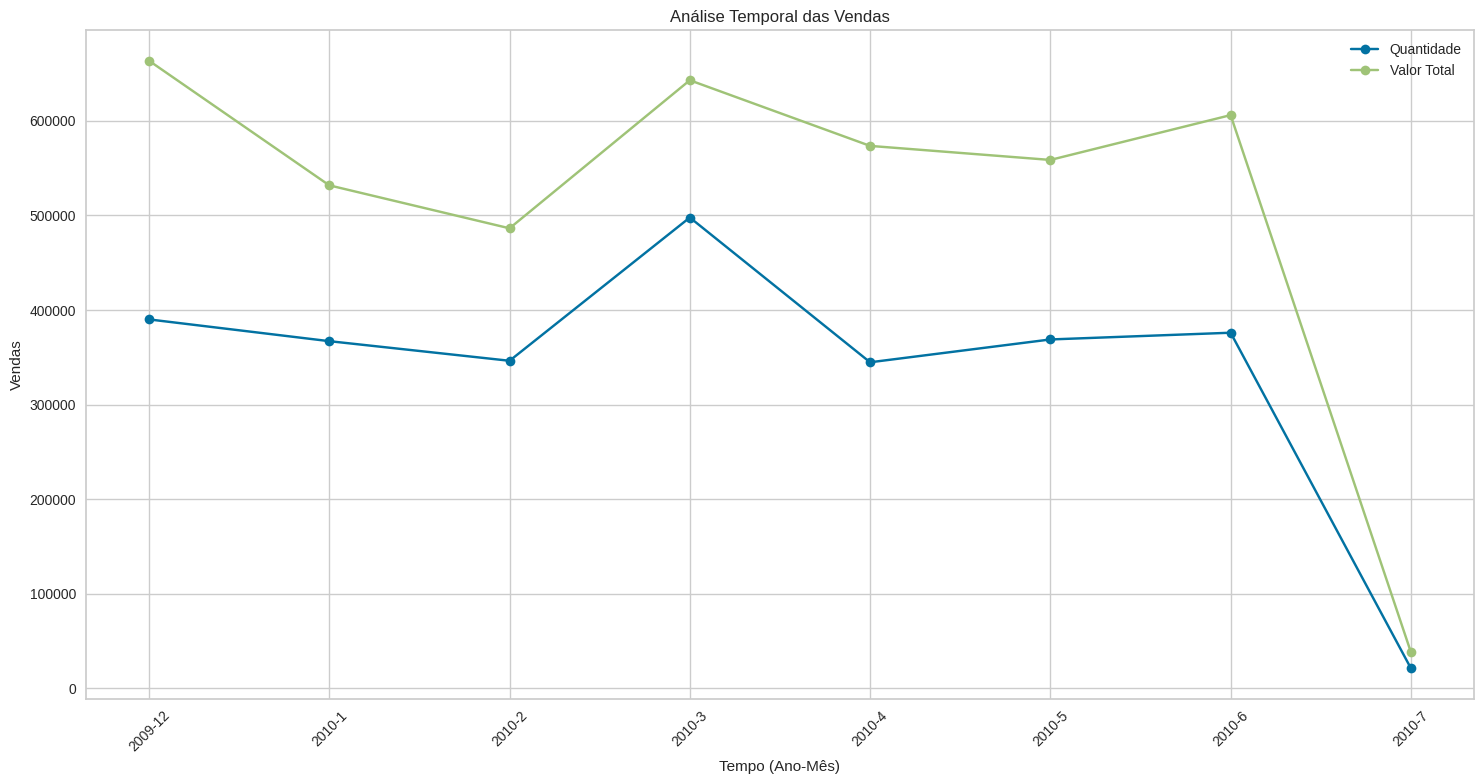

In [12]:
temporal_df = df.withColumn("Year", year("InvoiceDate")).withColumn("Month", month("InvoiceDate"))
temporal_agg_df = temporal_df.groupBy("Year", "Month").agg(sum("Quantity").alias("TotalQuantity"), sum(expr("Quantity * Price")).alias("TotalValue")).orderBy("Year", "Month")
temporal_agg_pd = temporal_agg_df.toPandas()

plt.figure(figsize=(15, 8))

plt.plot(temporal_agg_pd["Year"].astype(str) + '-' + temporal_agg_pd["Month"].astype(str), temporal_agg_pd["TotalQuantity"], label="Quantidade", marker='o')

plt.plot(temporal_agg_pd["Year"].astype(str) + '-' + temporal_agg_pd["Month"].astype(str), temporal_agg_pd["TotalValue"], label="Valor Total", marker='o')

plt.title("Análise Temporal das Vendas")
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Vendas")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# quem compra PINK REGENCY TEACUP AND SAUCER e ROSES REGENCY TEACUP AND SAUCER também compra GREEN REGENCY TEACUP AND SAUCER
df = df.withColumn("TotalSpent", col("Quantity") * col("Price"))
# Adicionar colunas de data
df = df.withColumn("DayOfWeek", dayofweek("InvoiceDate"))
df = df.withColumn("HourOfDay", hour("InvoiceDate"))

# Calcular RFM
recency_df = df.groupBy("Customer ID").agg(datediff(current_date(), max("InvoiceDate")).alias("Recency"))
frequency_df = df.groupBy("Customer ID").agg(count("Invoice").alias("Frequency"))
monetary_df = df.groupBy("Customer ID").agg(sum("TotalPrice").alias("Monetary"))

rfm_df = recency_df.join(frequency_df, "Customer ID").join(monetary_df, "Customer ID")

avg_spent_per_purchase_df = df.groupBy("Customer ID").agg((sum("TotalPrice") / countDistinct("Invoice")).alias("AvgSpentPerPurchase"))
variety_of_products_df = df.groupBy("Customer ID").agg(countDistinct("StockCode").alias("VarietyOfProducts"))

feature_df = rfm_df.join(avg_spent_per_purchase_df, "Customer ID").join(variety_of_products_df, "Customer ID")

feature_df = feature_df.orderBy(col("Monetary").desc())

feature_df.show()

# Análise de Cohorts
cohort_df = df.groupBy("Customer ID").agg(min("InvoiceDate").alias("CohortDate"))
cohort_df = cohort_df.withColumn("CohortYear", year("CohortDate")).withColumn("CohortMonth", month("CohortDate"))

cohort_df.show()

basket_data = df.groupBy("Invoice").agg(collect_set("StockCode").alias("Items"))
from pyspark.ml.fpm import FPGrowth
# Aplicar algoritmo FPGrowth
fpgrowth = FPGrowth(itemsCol="Items", minSupport=0.01, minConfidence=0.01)
model = fpgrowth.fit(basket_data)

model.freqItemsets.orderBy(col("freq").desc()).show(truncate=False)

model.associationRules.orderBy(col("confidence").desc()).show(truncate=False)


+-----------+-------+---------+------------------+-------------------+-----------------+
|Customer ID|Recency|Frequency|          Monetary|AvgSpentPerPurchase|VarietyOfProducts|
+-----------+-------+---------+------------------+-------------------+-----------------+
|    18102.0|   5303|      420|168173.46999999986|  3297.519019607842|              213|
|    14646.0|   5298|      866|127515.56999999992|  3036.085000000001|              338|
|    14156.0|   5296|     1472|112850.04999999987| 1589.4373239436616|              715|
|    13694.0|   5297|      792|100582.22000000004| 1156.1174712643679|              551|
|    14911.0|   5295|     2681| 62437.15000000013| 495.53293650793654|             1192|
|    17511.0|   5317|      540| 41466.60000000001| 2182.4526315789467|              315|
|    16754.0|   5296|      142|          36365.15| 1298.7553571428575|               37|
|    15311.0|   5312|     1431| 36182.52000000004| 369.20938775510206|              492|
|    15061.0|   5310|

In [14]:
# Filtrar para transações onde StockCode = '85123A'
item_85123A_df = df.filter(col("StockCode") == '22698')

# Visualizar todas as informações relacionadas ao item 85123A
item_85123A_info = item_85123A_df.toPandas()

# Exibir as informações
print(f'Informações sobre o item com StockCode = 85123A:')
print(item_85123A_info)


Informações sobre o item com StockCode = 85123A:
Empty DataFrame
Columns: [Invoice, StockCode, Description, Quantity, InvoiceDate, Price, Customer ID, Country, TotalPrice, TotalSpent, DayOfWeek, HourOfDay]
Index: []


In [15]:
df.select("Customer ID").distinct().count()

2994

In [17]:
# Preencher valores nulos na coluna Description
df = df.fillna({'Description': 'No description'})

# Eliminar linhas onde Customer ID é nulo
df = df.filter(col("Customer ID").isNotNull())

# Criar uma nova coluna 'Returns' que indica o número de devoluções
df = df.withColumn("Returns", when(col("Quantity") < 0, col("Quantity").cast("int") * -1).otherwise(0))

# Calcular TotalSpent
df = df.withColumn("TotalSpent", col("Quantity") * col("Price"))

# Calcular RFM e outras variáveis
recency_df = df.groupBy("Customer ID").agg(datediff(current_date(), max("InvoiceDate")).alias("Recency"))
frequency_df = df.groupBy("Customer ID").agg(count("Invoice").alias("Frequency"))
monetary_df = df.groupBy("Customer ID").agg(sum("TotalSpent").alias("Monetary"))
avg_spent_per_purchase_df = df.groupBy("Customer ID").agg((sum("TotalSpent") / countDistinct("Invoice")).alias("AvgSpentPerPurchase"))
variety_of_products_df = df.groupBy("Customer ID").agg(countDistinct("StockCode").alias("VarietyOfProducts"))
returns_df = df.groupBy("Customer ID").agg(sum("Returns").alias("TotalReturns"))
# Calcular o ciclo de compras (Shopping Cycle) para cada cliente
shopping_cycle_df = df.groupBy("Customer ID").agg(
    datediff(max("InvoiceDate"), min("InvoiceDate")).alias("Shopping_Cycle")
)

# Mostrar os resultados
#shopping_cycle.show(truncate=False)


# Unir todas as variáveis em um único DataFrame
feature_df = recency_df.join(frequency_df, "Customer ID") \
                       .join(monetary_df, "Customer ID") \
                       .join(avg_spent_per_purchase_df, "Customer ID") \
                       .join(variety_of_products_df, "Customer ID") \
                       .join(returns_df, "Customer ID") \
                       .join(shopping_cycle_df, "Customer ID")

# Filtrar os dados com Monetary >= 0
feature_df = feature_df.filter(col("Monetary") >= 0)
quantile_99 = feature_df.approxQuantile("Monetary", [0.99], 0.01)[0]
filtered_df = feature_df.filter(feature_df.Monetary < quantile_99)

# Transformar as features em um único vetor
assembler = VectorAssembler(inputCols=["Recency", "Frequency", "Monetary", "AvgSpentPerPurchase", "VarietyOfProducts", "TotalReturns", "Shopping_Cycle"], outputCol="temp_features")
temp_features = assembler.transform(filtered_df)

# Normalizar as características
scaler = StandardScaler(inputCol="temp_features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(temp_features)
scaled_data = scaler_model.transform(temp_features)

# Função para extrair elementos do vetor
def extract_element(v, i):
    try:
        return float(v[i])
    except IndexError:
        return None

extract_element_udf = udf(extract_element, FloatType())

scaled_data = scaled_data.withColumn("scaledRecency", extract_element_udf(col("scaled_features"), lit(0))) \
                         .withColumn("scaledFrequency", extract_element_udf(col("scaled_features"), lit(1))) \
                         .withColumn("scaledMonetary", extract_element_udf(col("scaled_features"), lit(2))) \
                         .withColumn("scaledAvgSpentPerPurchase", extract_element_udf(col("scaled_features"), lit(3))) \
                         .withColumn("scaledVarietyOfProducts", extract_element_udf(col("scaled_features"), lit(4))) \
                         .withColumn("scaledTotalReturns", extract_element_udf(col("scaled_features"), lit(5))) \
                         .withColumn("scaledShopping_Cycle", extract_element_udf(col("scaled_features"), lit(6)))

scaled_data = scaled_data.withColumn("scaledRecency", when(col("scaledRecency").isNull(), 0).otherwise(col("scaledRecency"))) \
                         .withColumn("scaledFrequency", when(col("scaledFrequency").isNull(), 0).otherwise(col("scaledFrequency"))) \
                         .withColumn("scaledMonetary", when(col("scaledMonetary").isNull(), 0).otherwise(col("scaledMonetary"))) \
                         .withColumn("scaledAvgSpentPerPurchase", when(col("scaledAvgSpentPerPurchase").isNull(), 0).otherwise(col("scaledAvgSpentPerPurchase"))) \
                         .withColumn("scaledVarietyOfProducts", when(col("scaledVarietyOfProducts").isNull(), 0).otherwise(col("scaledVarietyOfProducts"))) \
                         .withColumn("scaledTotalReturns", when(col("scaledTotalReturns").isNull(), 0).otherwise(col("scaledTotalReturns"))) \
                         .withColumn("scaledShopping_Cycle", when(col("scaledShopping_Cycle").isNull(), 0).otherwise(col("scaledShopping_Cycle")))

scaled_data = scaled_data.na.drop()

# Manter apenas a coluna features para o K-Means
assembler = VectorAssembler(inputCols=["scaledRecency", "scaledFrequency", "scaledMonetary", "scaledAvgSpentPerPurchase", "scaledVarietyOfProducts", "scaledTotalReturns"], outputCol="features")
final_df = assembler.transform(scaled_data).select("features")

# Excluir as colunas não normalizadas
final_df = scaled_data.select("scaledRecency", "scaledFrequency", "scaledMonetary", "scaledShopping_Cycle")
#"scaledAvgSpentPerPurchase", "scaledTotalReturns" "scaledVarietyOfProducts"


In [ ]:
final_df.show()

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(2, 10),
                 timings=False)

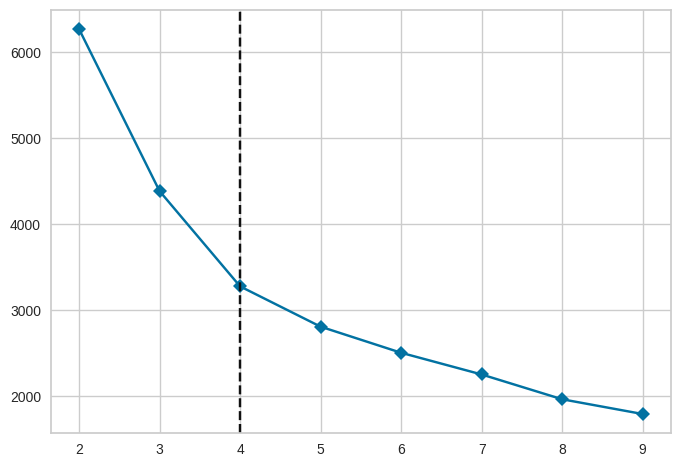

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import pandas as pd
# Aplicar Análise do Cotovelo
# o KElbowVisualizer auxilia na seleção do número ideal de clusters para algoritmos de agrupamento, o método do cotovelo é utilizado
# onde a distorção (soma das distâncias quadráticas dos pontos aos centros) é plotada em função do número de clusters (K)
# O ponto onde a curva se achata indica o número ideal de clusters.
# Converter as colunas normalizadas para um Pandas DataFrame
final_df_pd = scaled_data.select("scaledRecency", "scaledFrequency", "scaledMonetary", "scaledVarietyOfProducts").toPandas()
# Aplicar Análise do Cotovelo
scaler = StandardScaler()
df_rfm_clip_scaled = scaler.fit_transform(final_df_pd)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
visualizer.fit(df_rfm_clip_scaled)

Calinski-Harabasz Score para K-Means: 2309.1195552418344
Silhouette Score para K-Means: 0.39542508125305176
Número de clientes únicos: 2994


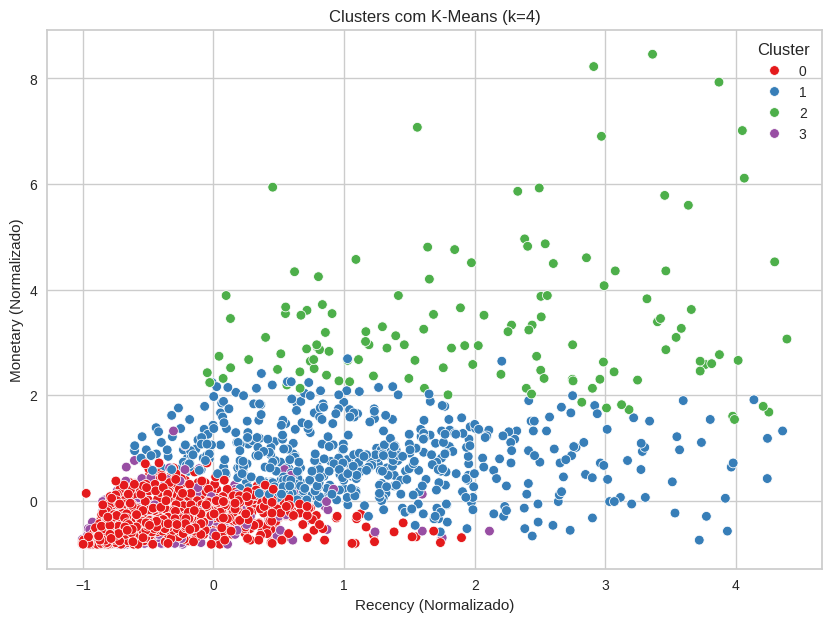

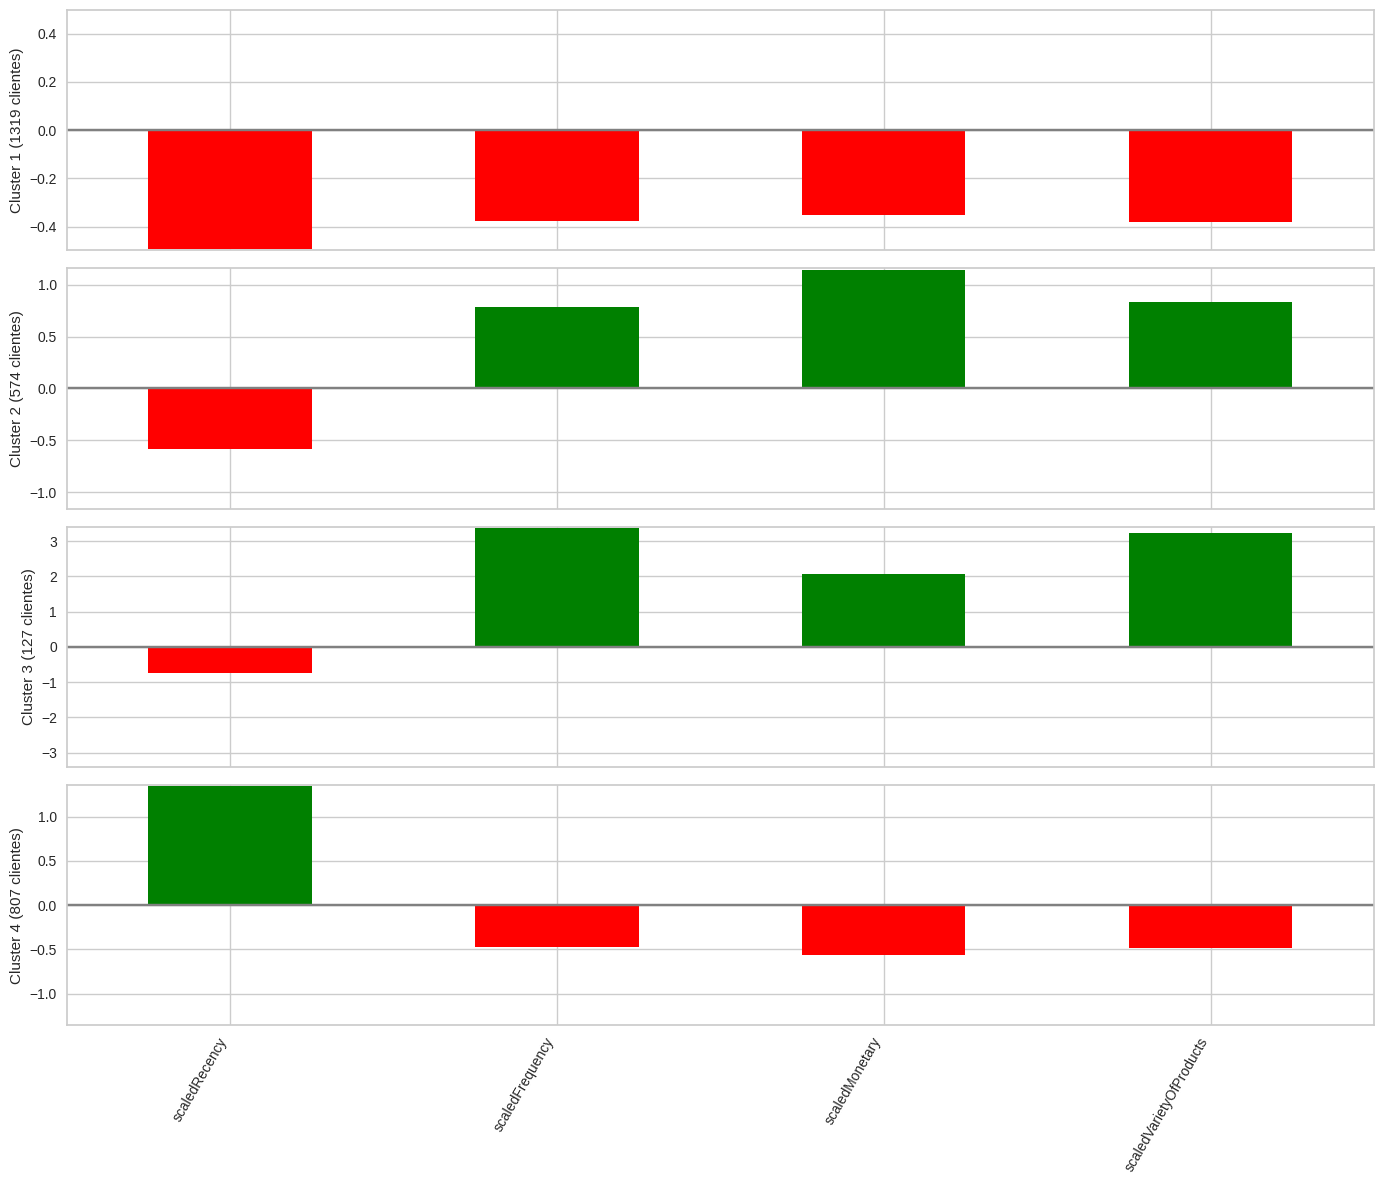

In [26]:
# Definir o número de clusters para Kmeans
k = 4

# Aplicar K-Means
kmeans = KMeans(n_clusters=k, random_state=1)
model = kmeans.fit(df_rfm_clip_scaled)

# Previsões de clusters
clusters_pd = final_df_pd.copy()
clusters_pd['prediction'] = model.labels_

# Calcular Calinski-Harabasz Score
ch_score_kmeans = calinski_harabasz_score(df_rfm_clip_scaled, model.labels_)
print(f'Calinski-Harabasz Score para K-Means: {ch_score_kmeans}')

# Calcular Silhouette Score
silhouette_score_kmeans = silhouette_score(df_rfm_clip_scaled, model.labels_)
print(f'Silhouette Score para K-Means: {silhouette_score_kmeans}')

# Contar o número de clientes únicos em PySpark
unique_customers_pyspark = df.select("Customer ID").distinct().count()
print(f'Número de clientes únicos: {unique_customers_pyspark}')

# Criar DataFrame com as características normalizadas e previsões de clusters
features_df = pd.DataFrame(df_rfm_clip_scaled, columns=["scaledRecency", "scaledFrequency", "scaledMonetary", "scaledVarietyOfProducts"])
features_df['prediction'] = clusters_pd['prediction']

# Plotar os clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=features_df, x="scaledMonetary", y="scaledFrequency", hue="prediction", palette="Set1")
plt.title(f'Clusters com K-Means (k={k})')
plt.xlabel('Recency (Normalizado)')
plt.ylabel('Monetary (Normalizado)')
plt.legend(title='Cluster')
plt.show()

# Cria um DataFrame com os centros dos clusters do K-Means
centers = pd.DataFrame(kmeans.cluster_centers_, columns=features_df.columns[:-1])

# Contar o número de clientes em cada cluster
cluster_counts = features_df['prediction'].value_counts().sort_index()

# Adaptado do livro "Practical Statistics for Data Scientists"
fig, axes = plt.subplots(nrows=k, figsize=(14, 12), sharex=True)

for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * center.abs().max()
    colors = ['green' if l > 0 else 'red' for l in center]
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i+1} ({cluster_counts[i]} clientes)')
    ax.set_ylim(-maxPC, maxPC)
    ax.axhline(color='gray')
    ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


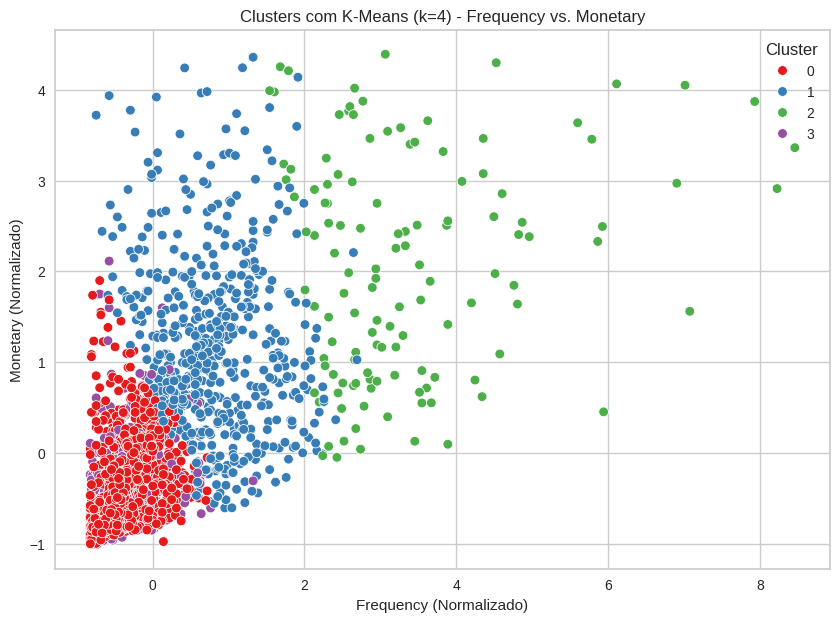

In [27]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=features_df, x="scaledFrequency", y="scaledMonetary", hue="prediction", palette="Set1")
plt.title(f'Clusters com K-Means (k={k}) - Frequency vs. Monetary')
plt.xlabel('Frequency (Normalizado)')
plt.ylabel('Monetary (Normalizado)')
plt.legend(title='Cluster')
plt.show()


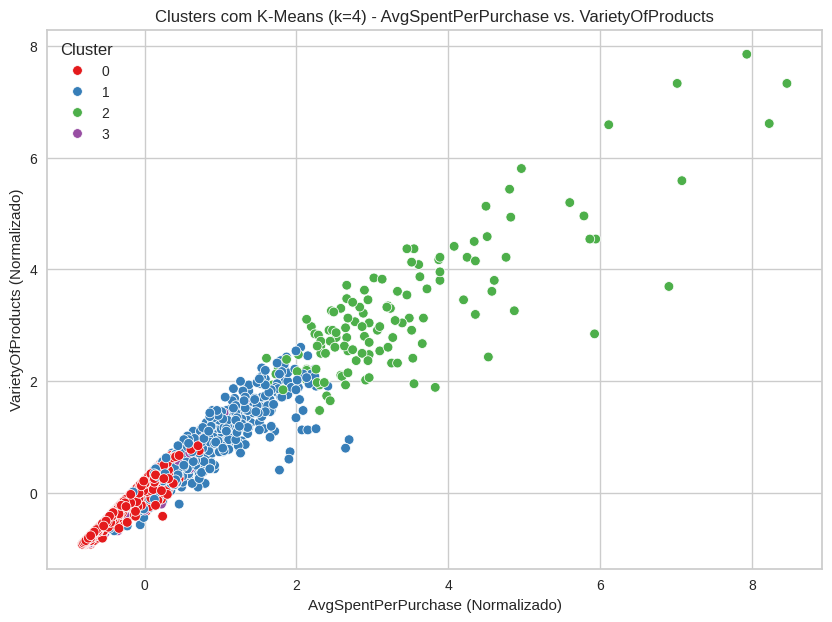

In [28]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=features_df, x="scaledFrequency", y="scaledVarietyOfProducts", hue="prediction", palette="Set1")
plt.title(f'Clusters com K-Means (k={k}) - AvgSpentPerPurchase vs. VarietyOfProducts')
plt.xlabel('AvgSpentPerPurchase (Normalizado)')
plt.ylabel('VarietyOfProducts (Normalizado)')
plt.legend(title='Cluster')
plt.show()


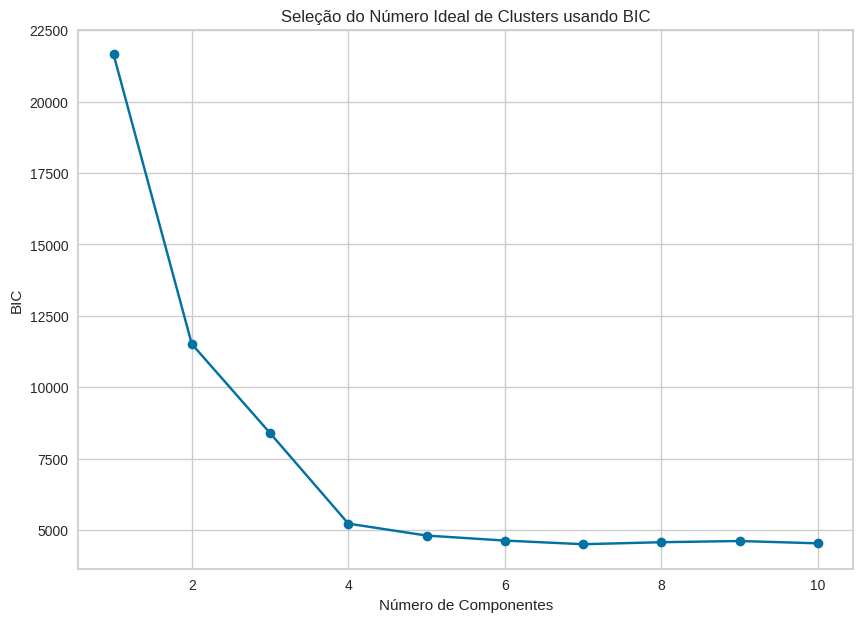

In [29]:
# Aplicar Gaussian Mixture Model
n_components = range(1, 11)
bics = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=1)
    gmm.fit(df_rfm_clip_scaled)
    bics.append(gmm.bic(df_rfm_clip_scaled))

plt.figure(figsize=(10, 7))
plt.plot(n_components, bics, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('BIC')
plt.title('Seleção do Número Ideal de Clusters usando BIC')
plt.show()

Calinski-Harabasz Score para Gaussian Mixture Model: 1050.716893438083
Silhouette Score para Gaussian Mixture Model: 0.07780980318784714


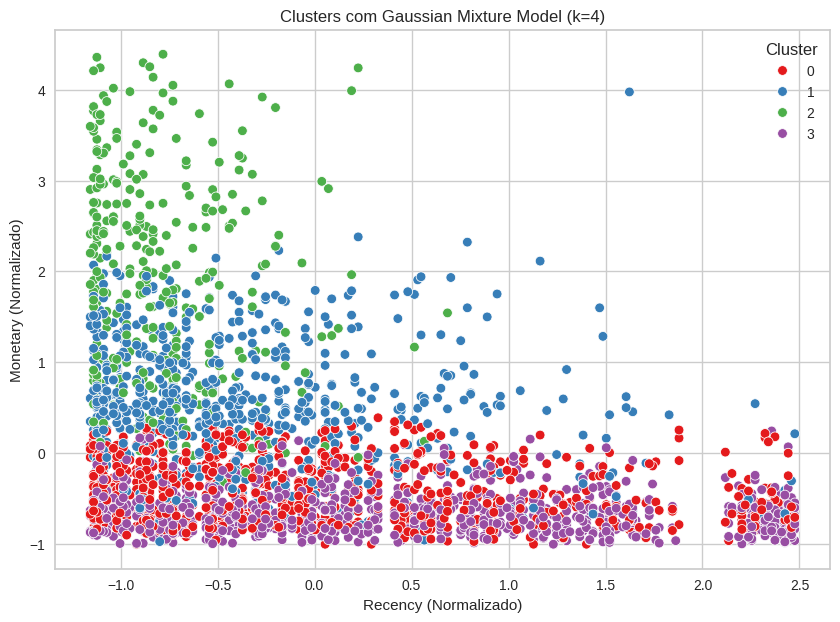

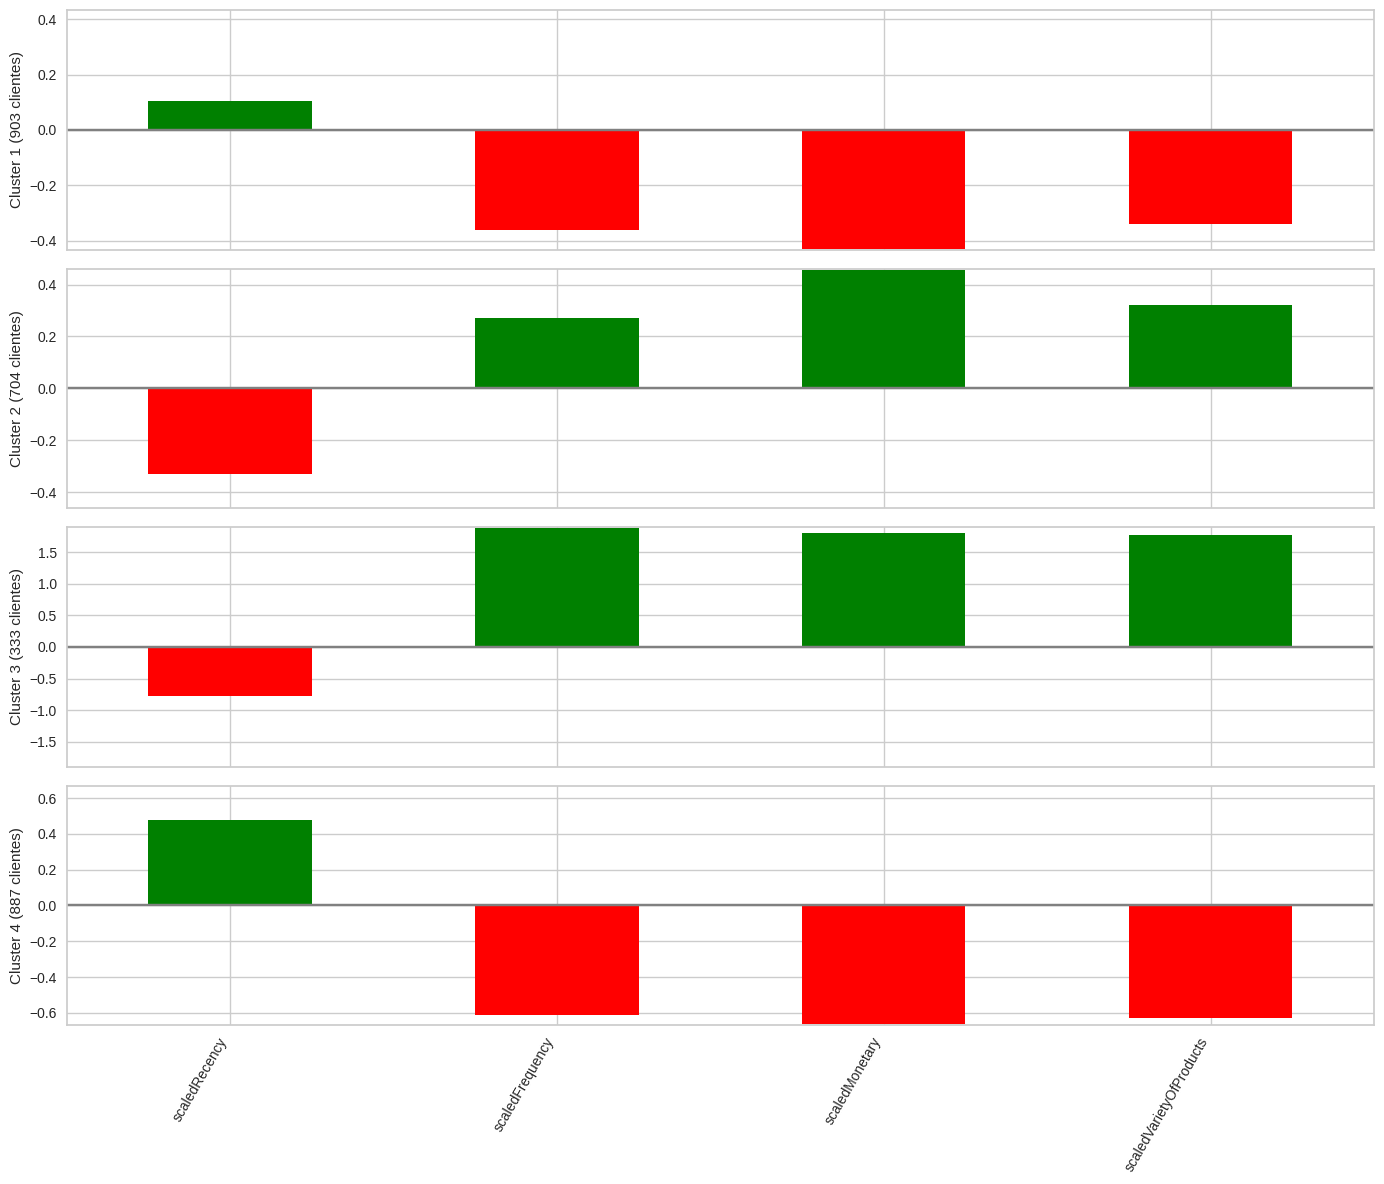

In [30]:
# Definir o número de clusters
ideal_clusters = 4

# Aplicar Gaussian Mixture Model com o número ideal de clusters
gmm = GaussianMixture(n_components=ideal_clusters, random_state=1)
gmm.fit(df_rfm_clip_scaled)

# Prever os clusters
clusters_gmm = gmm.predict(df_rfm_clip_scaled)

# Calcular Calinski-Harabasz Score
ch_score_gmm = calinski_harabasz_score(df_rfm_clip_scaled, clusters_gmm)
print(f'Calinski-Harabasz Score para Gaussian Mixture Model: {ch_score_gmm}')

# Calcular Silhouette Score
silhouette_score_gmm = silhouette_score(df_rfm_clip_scaled, clusters_gmm)
print(f'Silhouette Score para Gaussian Mixture Model: {silhouette_score_gmm}')

# Criar DataFrame com as características normalizadas e previsões de clusters
features_df = pd.DataFrame(df_rfm_clip_scaled, columns=["scaledRecency", "scaledFrequency", "scaledMonetary", "scaledVarietyOfProducts"])
features_df['prediction'] = clusters_gmm

# Contar o número de clientes em cada cluster
cluster_counts = features_df['prediction'].value_counts().sort_index()

# Plotar os clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=features_df, x="scaledRecency", y="scaledMonetary", hue="prediction", palette="Set1")
plt.title(f'Clusters com Gaussian Mixture Model (k={ideal_clusters})')
plt.xlabel('Recency (Normalizado)')
plt.ylabel('Monetary (Normalizado)')
plt.legend(title='Cluster')
plt.show()

# Cria um DataFrame com os centros dos clusters do GMM
centers = pd.DataFrame(gmm.means_, columns=features_df.columns[:-1])

# Adaptado do livro "Practical Statistics for Data Scientists"
fig, axes = plt.subplots(nrows=ideal_clusters, figsize=(14, 12), sharex=True)

for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * center.abs().max()
    colors = ['green' if l > 0 else 'red' for l in center]
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i+1} ({cluster_counts[i]} clientes)')
    ax.set_ylim(-maxPC, maxPC)
    ax.axhline(color='gray')
    ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

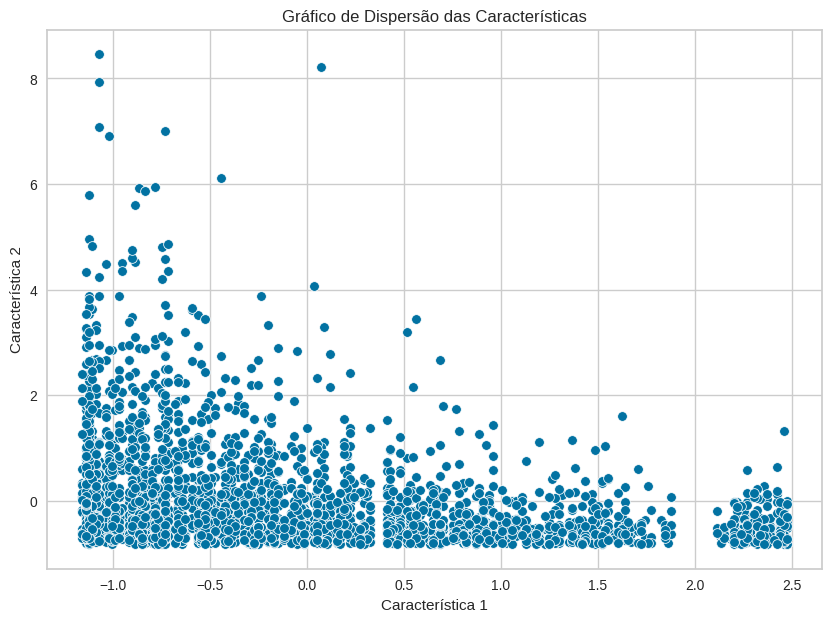

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotar um gráfico de dispersão das duas primeiras características
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_rfm_clip_scaled[:, 0], y=df_rfm_clip_scaled[:, 1])
plt.title('Gráfico de Dispersão das Características')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()


## Escolha do modelo

## K-Means vs Gaussian Mixture Model (GMM)

### Resultados das Métricas
#### GMM:

Calinski-Harabasz Score: 1092.76

Silhouette Score: 0.0619

#### K-Means:

Calinski-Harabasz Score: 2930.18

Silhouette Score: 0.3716


## Interpretação
### Calinski-Harabasz Score:
Valores mais altos indicam clusters bem definidos e separados. O K-Means obteve um score significativamente maior.

### Silhouette Score:
Valores mais próximos de 1 indicam melhor agrupamento e separação. O K-Means também apresentou um score muito superior.


##Decisão
Escolhemos o K-Means, pois formou clusters mais compactos e bem definidos, proporcionando uma análise mais precisa e útil para nossos dados.